# GIA - APRNS

## Sesión: Flujos

Esta sesión de laboratorio vamos a probar los diferentes modelos de flujos que hemos visto en teoría.

Como recordaréis estos modelos permiten transformar una distribución de probabilidad en otra a partir de una función de transformación que es invertible (aparte de derivable y monótona).

Esta función de transformación permite estimación y muestreo de una distribución compleja a partir de su correspondencia con una distribución más simple. En el caso de que partamos de la distribución gausiana estos modelos se llaman flujos normalizantes.


Para los ejemplos de modelos de flujos usaremos la libreria `normflows`. Antes de ejecutar el notebook deberemos instalarla descomentando la siguiente celda. Una vez instalada deberemos **reiniciar** el notebook para que este disponible (en colab no debería hacer falta)

<font color='red' size=4> Antes de inciar el notebook descarga el modelo preentenado que hay para la sesion y subelo a colab</font>


In [ ]:
!pip install --quiet normflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from torch.optim import lr_scheduler
import torch

import normflows as nf

from matplotlib import pyplot as plt

from tqdm import tqdm
import numpy as np
from sklearn.datasets import make_moons

from time import time
from datetime import timedelta
init_time = time()

device = torch.device("cuda")

torch.__version__, torch.cuda.is_available(), device

('2.5.1+cu121', True, device(type='cuda'))

In [ ]:
!nvidia-smi

Fri Dec  6 11:45:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Funciones auxiliares

Esta función realiza el entrenamiento de un modelo y retorna el valor de la función de pérdida de todo el entrenamiento. La función de pérdida de todos los modelos es la divergencia de Kullback-Leibler

Solo utiliza una muestra de entrenamiento, si queréis que se use una muestra de test para poder usarla para monitorizar la sobre especialización o usarla para terminar el entrenamiento deberéis modificar la función.

In [ ]:
# Training loop para los diferentes modelos
def train_loop(model, optimizer, scheduler, dataloader, epochs, conditional=False):
    hist_loss = []
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        running_loss = 0.0
        for i, data in enumerate(dataloader):
            optimizer.zero_grad()

            # calcula la pérdida dependiendo de si es condicional o no
            if not conditional:
                loss = model.forward_kld(data.to(device))
            else:
                loss = model.forward_kld(data[0].to(device), data[1].to(device))

            # si la pérdida no es nan o inf, hace el backpropagation
            if ~(torch.isnan(loss) | torch.isinf(loss)):
                loss.backward()
                optimizer.step()

            # guarda la pérdida
            running_loss += loss.item()

        if scheduler is not None:
            scheduler.step()
            lr = f'lr: {scheduler.get_last_lr()[0]:.4E}'
        else:
            lr = ''

        hist_loss.append(running_loss / i)
        pbar.set_description(f'loss: {running_loss / i:3.4f}:{lr}')

    return hist_loss

In [ ]:
# Cambiar para reducir o aumentar el tiempo de entrenamiento
epochs = 500

# Once in a blue moon

Como ejemplo sencillo comprobaremos que se puede transformar un conjunto de datos que tiene una distribución en otra más sencilla (gausiana) y a partir de ese modelo podemos generar muestras usando la transformación en sentido inverso.

Para ello generaremos un conjunto de muestras del dataset two moons que consiste en dos lunas crecientes imbricadas (no linealmente separables), por lo que tenemos una distribución bimodal que modelizaremos con una gausiana unimodal.

In [ ]:
X,_ = make_moons(2048, noise=0.1)

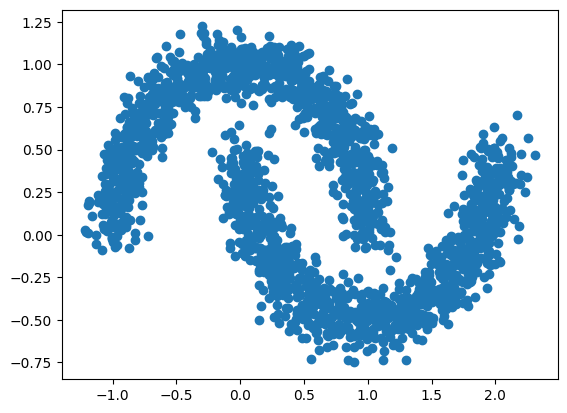

In [ ]:
plt.scatter(X[:,0], X[:,1]);

Definimos el flujo que tiene como distribución base una gausiana bidimensional ($N(0,1)$) y usamos una secuencia de transformaciones compuestas por flujos afines y permutaciones. Los flujos afines calculan traslaciones y escalados usando un MLP de dos capas. Este flujo sigue la transformación de RealNVP aplicando la transformación a la mitad de las variables (una variable) y dejando tal cual la otra mitad (una variable). La capa de permutación intercambia las variables que se transforman.

Se elige un número de capas suficiente para que el flujo tenga expresividad.

In [ ]:
base = nf.distributions.base.DiagGaussian(2)

# Definir la lista de capas del flow
num_layers = 5
flows = []
for i in range(num_layers):
    # Los parametros del Affine Coupling Flow se calculan con una red neuronal
    # Cada capa transforma la mitad de los parametros y calcula la traslacion y el escalado
    # El tamaño de entrada de la red es #variables/2 y la salida es el escalado y traslacion
    param_map = nf.nets.MLP([1, 32, 32, 2], init_zeros=True)
    # Capa de Affine Coupling
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Capa que intercambia las variables
    flows.append(nf.flows.Permute(2, mode='swap'))

# Definimos el flujo a partir de la distribucion base y las capas del flujo
model_2m = nf.NormalizingFlow(base, flows).to(device)

Creamos un data loader para los datos

In [ ]:
moons_dl = torch.utils.data.DataLoader(torch.tensor(X).type(torch.float32), batch_size=128)

Optimizamos el modelo por un numero suficiente de epochs

loss: 1.1574:lr: 6.0638E-04: 100%|██████████| 500/500 [01:30<00:00,  5.53it/s]


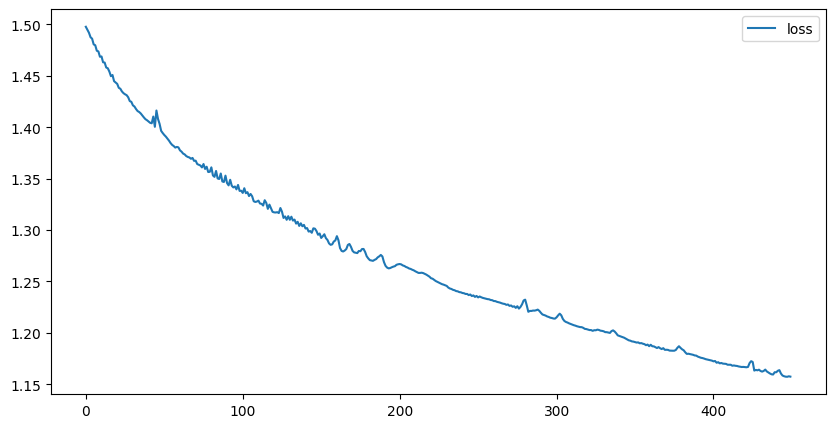

In [ ]:
optimizer = torch.optim.Adamax(model_2m.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda _: 0.999)

loss_hist = train_loop(model_2m, optimizer, scheduler, moons_dl, epochs)

plt.figure(figsize=(10, 5))
plt.plot(loss_hist[epochs//10:], label='loss')
plt.legend()
plt.show()

Una vez entrenado el modelo podemos usarlo para obtener muestras. Podemos ver que el ajuste no es perfecto, pero sí obtenemos dos modalidades que siguen la distribución original. Fijaos que para muestrear estamos obteniendo una muestra gausiana y simplemente la estamos transformado mediante el modelo usando el hecho de que es una función invertible para obtener la muestra de la distribución original.

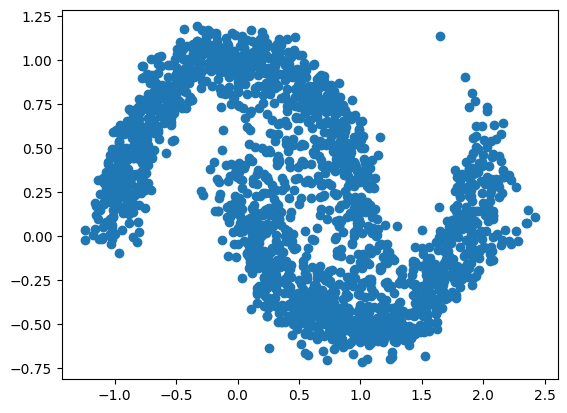

In [ ]:
samples = model_2m.sample(num_samples=2048)[0].cpu().detach().numpy()
plt.scatter(samples[:,0], samples[:,1]);

Si queremos podemos partir de una distribución base que se parezca más a la distribución objetivo, por ejemplo podemos usar una mezcla de gausianas que sea bimodal para hacer más sencilla la correspondencia.

In [ ]:
# Definimos una mezcla de gausianas bimodal
baseGM = nf.distributions.base.GaussianMixture(2,2, loc=np.array([[-2,0],[2,0]], dtype=np.float32),scale=np.array([[0.3,0.3],[0.3,0.3]], dtype=np.float32))

Definimos el nuevo modelo con el mismo flujo (queda como ejercicio para el lector el probar si un flujo más pequeño es ahora suficiente para obtener un buen resultado)

In [ ]:
model_2m_GM = nf.NormalizingFlow(baseGM, flows).to(device)

Optimizamos el nuevo modelo

loss: 1.0894:lr: 6.0638E-04: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]


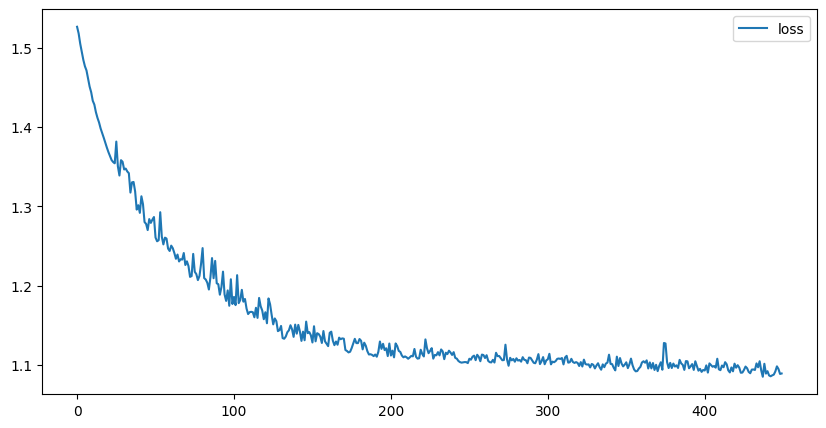

In [ ]:
optimizer = torch.optim.Adamax(model_2m_GM.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda _: 0.999)
epochs = 500
loss_hist = train_loop(model_2m_GM, optimizer, scheduler, moons_dl, epochs)

plt.figure(figsize=(10, 5))
plt.plot(loss_hist[epochs//10:], label='loss')
plt.legend()
plt.show()

Muestreando podemos ver que el ajuste es algo mejor que el que tenemos con la gausiana unimodal y converge más rápidamente.

Obviamente podemos aumentar el número de capas en el flujo de la gausiana unimodal o hacer más iteraciones y probablemente obtengamos un ajuste parecido, pero con mas coste computacional

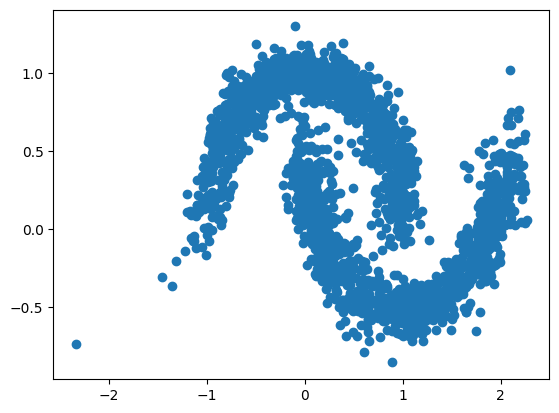

In [ ]:
samples = model_2m_GM.sample(num_samples=2048)[0].cpu().detach().numpy()
plt.scatter(samples[:,0], samples[:,1]);

# Flujos - Digits Dataset

Ahora probaremos los diferentes modelos vistos en clase usando el mismo conjunto de datos que en laboratorio anterior.

In [ ]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

Seleccionaremos también el digito `0`

In [ ]:
Xo,y = load_digits(n_class=10, return_X_y=True)
X = Xo[y==0]

Ahora modelamos los digitos como variables continuas (no binarizados), las normalizamos de manera que estén en el rango [-1,1]

In [ ]:
digits_dl = torch.utils.data.DataLoader(torch.tensor((X/8)-1).type(torch.float32), batch_size=64)

## Masked Autoregressive Flow

Empezaremos por los flujos autoregresivos. En este caso usamos capas que modelan la transformación como una distribución autoregresiva basada en el modelo MADE que vimos la sesión pasada.

Definimos una distribución base que tiene el número de dimensiones que corresponde al tamaño de los digitos.

In [ ]:
base = nf.distributions.base.DiagGaussian(64)

Definimos el flujo auto regresivo a partir de capas basadas en MADE.

In [ ]:
# Definimos las capas del flujo
num_layers = 2
flows = []
for i in range(num_layers):
    # Cada capa tiene como entrada el numero de variables y un modelo MADE con cierto numero de
    # neuronas y capas
    flows.append(nf.flows.MaskedAffineAutoregressive(features=64, hidden_features=96, num_blocks=2))

# Definimos el flujo
MAF = nf.NormalizingFlow(base, flows).to(device)

Ahora entrenamos el flujo.

loss: -138.6630:lr: 9.6079E-03: 100%|██████████| 400/400 [04:35<00:00,  1.45it/s]


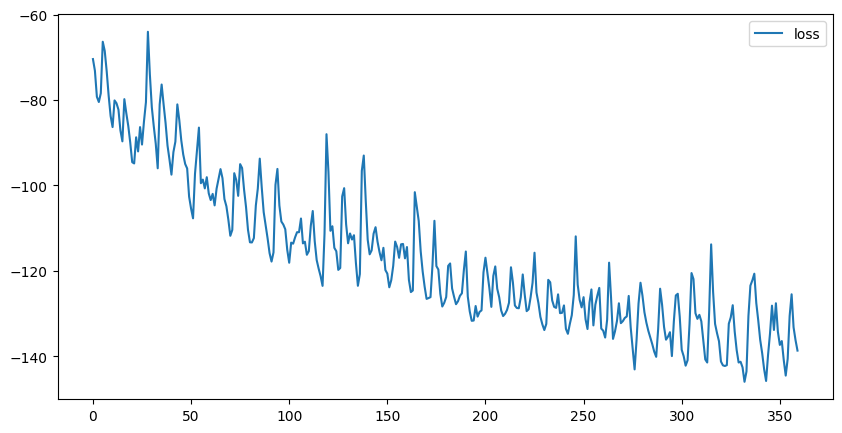

In [ ]:
optimizer = torch.optim.Adamax(MAF.parameters(), lr=1e-2, weight_decay=1e-5)
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda _: 0.9999)
epochs = 400
loss_hist = train_loop(MAF, optimizer, scheduler, digits_dl, epochs)

plt.figure(figsize=(10, 5))
plt.plot(loss_hist[epochs//10:], label='loss')
plt.legend()
plt.show()

Ahora podemos generar muestras a partir del modelo, igual que antes, muestreando una gausiana de 64 dimensiones y transformando la muestra a través de la función inversa del flujo en un dígito.

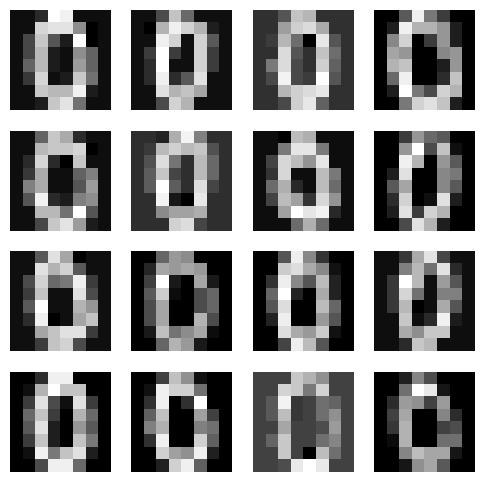

In [ ]:
nim = 4
samples = MAF.sample(num_samples=nim*nim)[0].cpu().detach().numpy()
fig = plt.figure(figsize=(6,6))
for i in range(nim*nim):
    plt.subplot(nim, nim, i+1)
    plt.imshow(np.trunc((samples[i].reshape(8,8)+1)*8),cmap='gray')
    plt.axis('off')

El propio modelo nos permite calcular la log likelihood de muestras, en este caso a través de la distribución gaussiana.

In [ ]:
MAF.log_prob(torch.tensor((X[:100]/8)-1, dtype=torch.float32).to(device)).detach().sum()

tensor(9196.4287, device='cuda:0')

## Conditioned Masked Autoregressive Flow

Al modelar una distribución, podemos darle información adicional que nos permita condicionar la generación, de esta manera podemos controlar el tipo de ejemplos que obtenemos.

Podemos condicionar a partir de cualquier informacion de que dispongamos. En este caso sabemos las etiquetas de las clases, podemos intentar generar más de un digito añadiendo la información de su clase como condicionamiento.

Creamos un dataloader para los digitos `2` y `6`

In [ ]:
class Digits(Dataset):
    def __init__(self, data, labels):
        self.data = torch.Tensor((data/8)-1).type(torch.float32)
        self.labels = torch.Tensor(labels).type(torch.float32).unsqueeze(1)


    def __getitem__(self, index):
        return self.data[index], self.labels[index]

    def __len__(self):
        return len(self.data)

digdata = Digits(Xo[np.logical_or(y==2, y==6)], y[np.logical_or(y==2, y==6)])
twodig_dl = torch.utils.data.DataLoader(digdata, batch_size=64)


Usamos la misma distribución base

In [ ]:
basec = nf.distributions.base.DiagGaussian(64)

El modelo MADE permite introducir cuantas características se usan en el condicionamiento (`context_features`). El modelo ya se encarga de usar la información adicional para condicionar la distribución de probabilidad

In [ ]:
# Definimos el flujo igual que el anterior
num_layers = 2
flows = []
for i in range(num_layers):
    flows.append(nf.flows.MaskedAffineAutoregressive(64, 96, context_features=1, num_blocks=2))

# Costruimos el flujo condicional
cMAF = nf.ConditionalNormalizingFlow(basec, flows).to(device)

In [ ]:
epochs = 100 # estos modelos tardan mas en Colab, ajustar para que tarden algo razonable

loss: -43.4448:lr: 4.9502E-03: 100%|██████████| 100/100 [03:07<00:00,  1.88s/it]


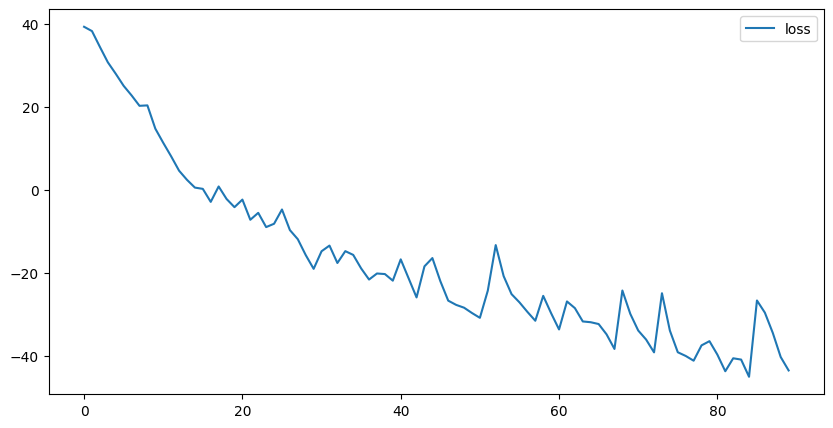

In [ ]:
optimizer = torch.optim.Adamax(cMAF.parameters(), lr=5e-3, weight_decay=1e-5)
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda _: 0.9999)

loss_hist = train_loop(cMAF, optimizer, scheduler, twodig_dl, epochs, conditional=True)

plt.figure(figsize=(10, 5))
plt.plot(loss_hist[epochs//10:], label='loss')
plt.legend()
plt.show()

Al muestrear simplemente le damos a la red el condicionamiento que se usara en el flujo para mapear desde la gausiana al digito correspondiente.

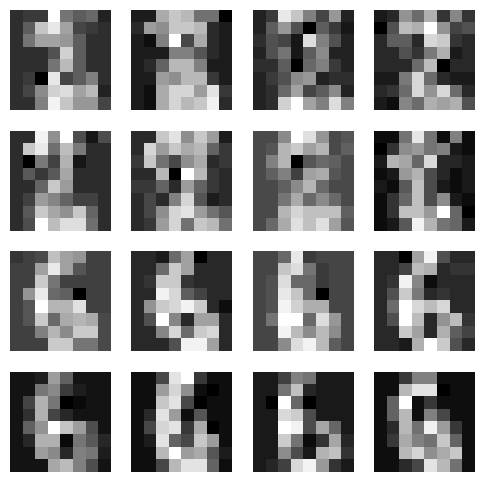

In [ ]:
nim = 4
c = ([2.0] * ((nim*nim)//2))  + ([6.0] * ((nim*nim)//2))
cond = torch.tensor([c]).type(torch.float32).to(device)
samples = cMAF.sample(num_samples=nim*nim, context=cond.T)[0].cpu().detach().numpy()
fig = plt.figure(figsize=(6,6))
for i in range(nim*nim):
    plt.subplot(nim, nim, i+1)
    plt.imshow(np.trunc((samples[i].reshape(8,8)+1)*8),cmap='gray')
    plt.axis('off')

## Affine Coupled Flow

Otra manera de definir los flujos es a través de transformaciones afines, es en lo que se basan los flujos NICE y RealNVP.

Esto es más paralelizable que usar una formulación auto regresiva ya que podemos aplicar la transformación en paralelo.

La idea de utilizar una transformacion afín es que esta define un jacobiano que es triangular, por lo que es computacionalmente poco costoso el hacer descenso de gradiente con la función de perdida (log likelihood)

Si recordáis como funcionan estos flujos, la idea es encadenar sucesivas capas donde transformamos la mitad de las variables y dejamos sin tocar el resto, en cada capa transformamos un conjunto de variables diferentes. La transformación (escalado/traslación) se calcula mediante una red neuronal.


In [ ]:
num_layers = 10
flows = []
for i in range(num_layers):
    # El MLP define la red que modeliza los parametros de la transformacion afin
    # traslacion/escalado como (media/variancia)
    param_map = nf.nets.MLP([32,64, 64, 64], init_zeros=True)
    # Affine transformation
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Reordenamos las variables
    flows.append(nf.flows.Permute(64, mode='shuffle'))

base = nf.distributions.base.DiagGaussian(64)

# Construimos el flow
acf = nf.NormalizingFlow(base, flows).to(device)


---
<font color="blue" size=4>
Responded a las siguientes preguntas
 </font>


- ¿Porqué el MLP tiene una entrada de 32 y una salida de 64? ¿a que corresponden esos parámetros?

- ¿que pasaría si no aplicaramos la capa de permutación despues de cada AffineCoupling?

---

In [ ]:
epochs = 1000 # estos modelos son mas rapidos, se puede reajustar de nuevo

loss: -155.5221:lr: 3.6770E-05: 100%|██████████| 1000/1000 [00:59<00:00, 16.70it/s]


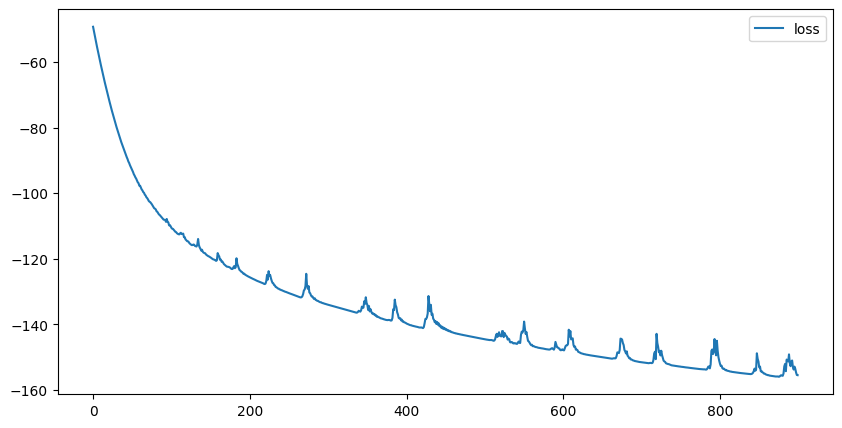

In [ ]:
optimizer = torch.optim.Adamax(acf.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda _: 0.999)

loss_hist = train_loop(acf, optimizer, scheduler, digits_dl, epochs)

plt.figure(figsize=(10, 5))
plt.plot(loss_hist[epochs//10:], label='loss')
plt.legend()
plt.show()

---

Los parametros de entrenamiento como siempre han sido _mágicamente_ ajustados

<font color="blue" size=4>
 Prueba diferentes valores para tasa de entrenamiento (mayores y menores que la fijada) y su tasa de decaimiento en el schedule y compara las diferencias en la log probabilidad que se obtiene
</font>

---

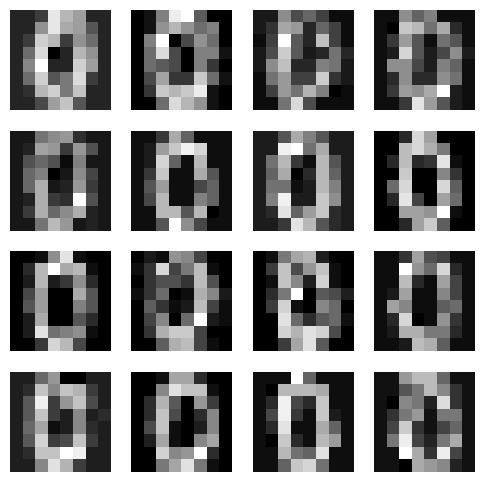

In [ ]:
nim = 4
samples = acf.sample(num_samples=nim*nim)[0].cpu().detach().numpy()
fig = plt.figure(figsize=(6,6))
for i in range(nim*nim):
    plt.subplot(nim, nim, i+1)
    plt.imshow(np.trunc((samples[i].reshape(8,8)+1)*8),cmap='gray')
    plt.axis('off')

In [ ]:
acf.log_prob(torch.tensor((X[:100]/8)-1, dtype=torch.float32).to(device)).detach().sum()

tensor(10376.1758, device='cuda:0')

## Real NVP

Podemos obtener flujos más complejos haciendo cambios a como se realizan las transformaciones.

Como hemos visto en teoría, Real NVP utiliza una transformación afin basada en un escalado y una traslación. En este caso las calculamos de manera independiente con un MLP y usamos enmascaramiento en lugar de permutaciones. El enmascaramiento que se usa alterna el uso de variables en orden consecutivo (en 2D es un tablero de ajedrez)  de manera que preservamos cierta localidad en cada capa de transformación. La normalización de las activaciones añadida tras cada transformación debería ayudar a estabilizar el entrenamiento (o no)

In [ ]:
K = 8
latent_size = 64
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(K):
    # Redes para calcular el escalamiento y el traslado
    s = nf.nets.MLP([latent_size, 2 * latent_size, 2 * latent_size,latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 2 * latent_size, 2 * latent_size,latent_size], init_zeros=True)
    # Enmascaramiento alternado para capas pares e impares
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    # Normalización de activacione para estabilizar el entrenamiento
    flows += [nf.flows.ActNorm(latent_size)]

rnvp = nf.NormalizingFlow(base,flows).to(device)

# Inicializamos la normalización de activaciones generando unas muestras
z, _ = rnvp.sample(num_samples=2 ** 7)

Más _magia_ se realizo para ajustar el entrenamiento de la red

In [ ]:
epochs = 1000 # Ajustar si tarda demasiado

loss: -200.7211:lr: 4.3171E-07: 100%|██████████| 1000/1000 [01:12<00:00, 13.82it/s]


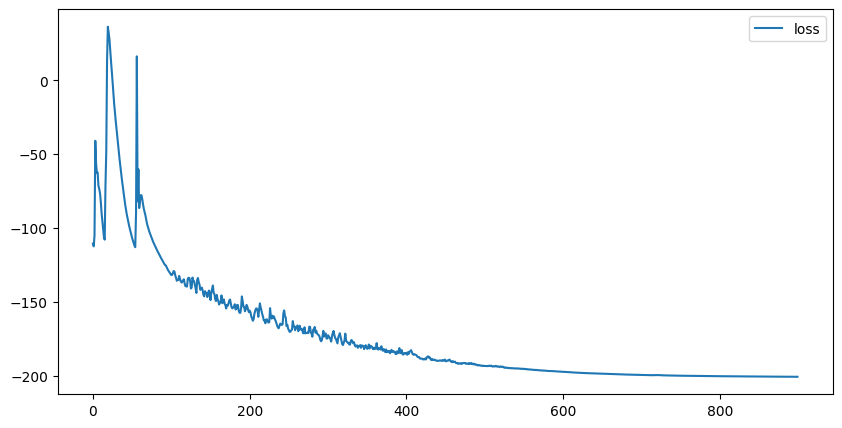

In [ ]:
optimizer = torch.optim.Adamax(rnvp.parameters(), lr=1e-2, weight_decay=1e-5)
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda _: 0.99)

loss_hist = train_loop(rnvp, optimizer, scheduler, digits_dl, epochs)

plt.figure(figsize=(10, 5))
plt.plot(loss_hist[epochs//10:], label='loss')
plt.legend()
plt.show()

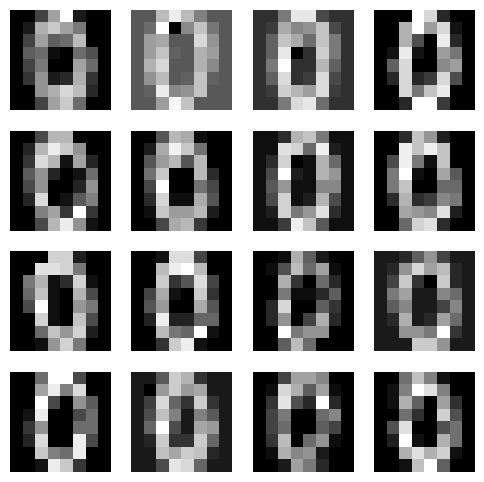

In [ ]:
nim = 4
samples = rnvp.sample(num_samples=nim*nim)[0].cpu().detach().numpy()
fig = plt.figure(figsize=(6,6))
for i in range(nim*nim):
    plt.subplot(nim, nim, i+1)
    plt.imshow(np.trunc((samples[i].reshape(8,8)+1)*8),cmap='gray')
    plt.axis('off')

La log probabilidad deberia haber mejorado

In [ ]:
rnvp.log_prob(torch.tensor((X[:100]/8)-1, dtype=torch.float32).to(device)).detach().sum()

tensor(13149.0137, device='cuda:0')

# The whole enchilada

Ahora vamos a usar un flujo que ha sido entrenado con el conjunto completo de datos.

Las siguientes celdas sirven para entrenarlo, pero puede tardar alrededor de 15 minutos (probablemente más en Colab), asi que saltaremos
a la celda donde cargamos el modelo ya preentrenado.

In [ ]:
digits_dl2 = torch.utils.data.DataLoader(torch.tensor((Xo/8)-1).type(torch.float32), batch_size=128)

Es la misma red que antes pero aumentando el número de parámetros

In [ ]:
K = 14
latent_size = 64
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(K):
    s = nf.nets.MLP([latent_size, 2 * latent_size, 2 * latent_size,latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 2 * latent_size, 2 * latent_size,latent_size], init_zeros=True)
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]

rnvp = nf.NormalizingFlow(base,flows).to(device)

z, _ = rnvp.sample(num_samples=2 ** 7)

Más ajuste mágico de hiper parámetros

In [ ]:
epochs = 200 # Ajustar a algo razonable para ver que entrena, usaremos un modelo preentrenado

loss: -105.1757:lr: 8.1865E-03: 100%|██████████| 200/200 [01:51<00:00,  1.79it/s]


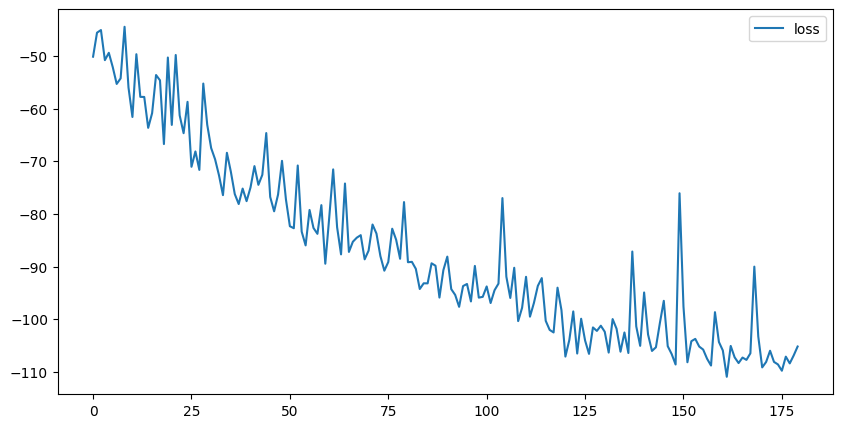

In [ ]:
optimizer = torch.optim.Adamax(rnvp.parameters(), lr=1e-2, weight_decay=1e-5)
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda _: 0.999)

loss_hist = train_loop(rnvp, optimizer, scheduler, digits_dl2, epochs)

plt.figure(figsize=(10, 5))
plt.plot(loss_hist[epochs//10:], label='loss')
plt.legend()
plt.show()

In [ ]:
# Cambiar si entrenamos lo suficiente
save_model = False
if save_model:
    torch.save(rnvp.state_dict(), '/content/rnvp-digits.pt' )

<font color="red" size=5> **Continuaremos ejecutando desde aqui**</font>


**Deberíais haber subido a Colab el modelo preentrenado que hay con el material de la sesión al directorio `/content`**

In [ ]:
lrnvp = nf.NormalizingFlow(base,flows)
lrnvp.load_state_dict(torch.load('/content/rnvp-digits.pt'))

<ipython-input-45-899b496a0d09>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lrnvp.load_state_dict(torch.load('/content/rnvp-digits.pt'))


FileNotFoundError: [Errno 2] No such file or directory: '/content/rnvp-digits.pt'

Si hacemos un muestreo veremos que nos genera cualquiera de los 10 dígitos

In [ ]:
nim = 4
samples = lrnvp.sample(num_samples=nim*nim)[0].cpu().detach().numpy()
fig = plt.figure(figsize=(6,6))
for i in range(nim*nim):
    plt.subplot(nim, nim, i+1)
    plt.imshow(np.trunc((samples[i].reshape(8,8)+1)*8),cmap='gray')
    plt.axis('off')

Una cosa interesante de los flujos es que un recorrido en espacio de la distribución de referencia (gausiana) nos sirve para recorrer el espacio del conjunto de datos. En particular podemos interpolar entre dos ejemplos obteniendo los puntos que corresponden en la gausiana y observar la transición entre ellos.

Escoge un par de ejemplos en los que sean reconocibles dos dígitos **diferentes** y asigna su posicion a las variables de la siguiente celda (la posición de la esquina superior izquierda es la cero)

In [ ]:
d1=0
d2=11

Usamos la transformacion inversa del flujo para obtener los puntos que les corresponden a las muestras en las gausianas

In [ ]:
start = rnvp.inverse(torch.tensor(samples[d1]).to(device))
end = rnvp.inverse(torch.tensor(samples[d2]).to(device))

Calculamos puntos equidistantes dentro del vector que conecta esos dos puntos dentro de la distribución gausiana

In [ ]:
interp = []

for v in torch.arange(0,1,0.1):
    interp.append(torch.lerp(start,end, v.to(device)))

Ahora podemos qué se encuentra en el recorrido entre las dos muestras simplemente aplicando el flujo a los puntos en la gausiana.

Dependiendo de como se haya hecho la correspondencia entre los digitos y la gausiana y donde se encuentren los digitos pueden aparecer otros digitos intermedios.

In [ ]:

fig = plt.figure(figsize=(15,10))
for i, v in enumerate(interp):
    plt.subplot(1, len(interp), i+1)
    plt.imshow(np.trunc((rnvp(v).cpu().detach().numpy().reshape(8,8)+1)*8),cmap='gray')
    plt.axis('off')

In [ ]:
print(f"Total Running time {timedelta(seconds=(time() - init_time))}")

---

# Olivetti Faces

 El dataset Olivetti Faces es un conjunto de datos que tiene 40 clases que corresponden a 10 fotografias de 40 personas. Son imagenes de 64x64, así que aprenderlas mediante un flujo directamente puede tardar mucho.

 Una posibilidad es aplicar un método de reduccion de dimensionalidad, aprender el flujo en ese espacio y utilizarlo para muestrear nuevas caras simplemete aplicando el inverso del metodo de reduccion de dimensionalidad.

 El conjunto de datos esta el `scikit-learn`, aplicaremos PCA como método de reduccion de dimensionalidad.

<font color="red" size=6>
Ejercicio de laboratorio entregable
</font>






> - Obten los datos del Olivetti Faces
- Aplica un PCA para obtener un nuevo conjunto de datos de dimensionalidad reducida donde la varianza explicada por los componentes principales sea alrededor del 90% (haz que sea una potencia de 2).
- Transforma los datos y crea con ellos un data loader
- Ajusta un flujo RealNVP como el que hemos hecho para los digitos
- Genera una muestra de los datos
- Calcula la log probabilidad de un subconjunto de los datos
- Haz una interpolacion entre dos de los ejemplos del conjunto de datos real para clases diferentes
- <font color="blue"> Haz un informe comentando lo que has hecho y explica las conclusiones que has sacado</font>

<font color="red"> Nota:</font> No esperes que la generación sea perfecta, no uses un tamaño de batch muy grande (solo hay 400 ejemplos), ten cuidado tambien al seleccionar la tasa de aprendizaje su decaimiento. Ten paciencia, tarda un rato.

In [1]:
!pip install --quiet normflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
!pip install tqdm

In [3]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA

In [4]:
from torch.optim import lr_scheduler
import torch

In [5]:
import torch
import torch.nn.functional as F
import normflows as nf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Load Olivetti Faces dataset
faces = fetch_olivetti_faces()
X = faces.data

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [6]:
# Apply PCA
pca = PCA(n_components=0.9)  # Retain 90% of variance
X_pca = pca.fit_transform(X)

# Find the next power of 2 for the number of components
latent_size = 2 ** int(np.log2(X_pca.shape[1]))
print(latent_size)

64


In [7]:
pca = PCA(n_components=64)  # Retain 90% of variance
X_pca = pca.fit_transform(X)

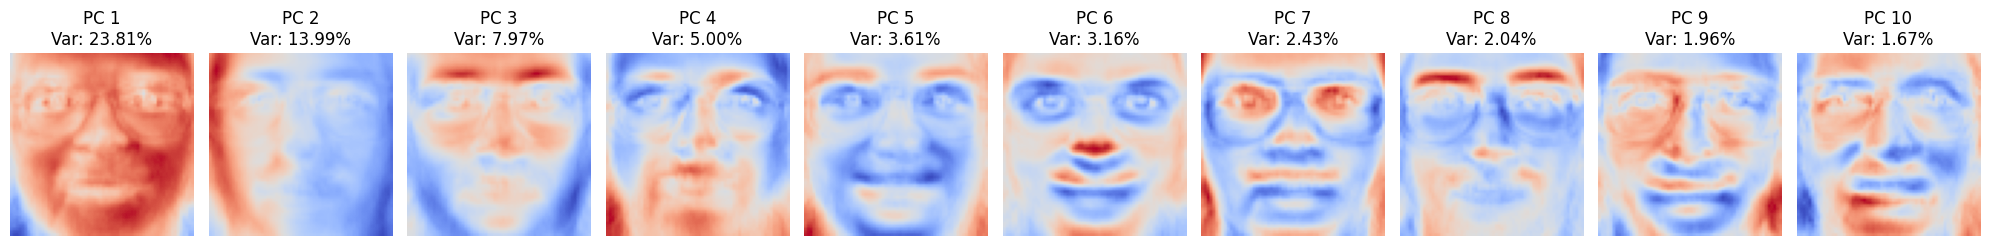

In [27]:
import matplotlib.pyplot as plt

# Reshape PCA components to 64x64 grids
components_reshaped = pca.components_.reshape(-1, 64, 64)

# Create a grid of plots for visualization
n_components_to_plot = 10  # Number of components to visualize
fig, axes = plt.subplots(1, n_components_to_plot//1, figsize=(20, 5))

for i, ax in enumerate(axes.flat):
    if i < n_components_to_plot:
        # Scale the component by its explained variance ratio
        ax.imshow(components_reshaped[i], cmap='coolwarm', aspect='equal')
        ax.set_title(f'PC {i+1}\nVar: {pca.explained_variance_ratio_[i]:.2%}')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


In [32]:
# NOT REALLY NEEDED :)
X_pca_padded = np.zeros((X_pca.shape[0], latent_size))
X_pca_padded[:, :X_pca.shape[1]] = X_pca

print(f"Original data shape: {X.shape}")
print(f"PCA transformed data shape: {X_pca.shape}")
print(f"Padded PCA data shape: {X_pca_padded.shape}")
print(f"Variance explained: {pca.explained_variance_ratio_.sum():.4f}")


Original data shape: (400, 4096)
PCA transformed data shape: (400, 64)
Padded PCA data shape: (400, 64)
Variance explained: 0.8970


In [33]:
from sklearn.model_selection import train_test_split
X_pca_train, X_pca_test = train_test_split(X_pca_padded, test_size=0.2, random_state=42)

In [34]:
# Prepare data loader
X_tensor = torch.tensor(X_pca_padded, dtype=torch.float32)
faces_dataset = TensorDataset(X_tensor)
faces_dataloader = DataLoader(faces_dataset, batch_size=64, shuffle=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
# Prepare data loader
X_tensor_test = torch.tensor(X_pca_test, dtype=torch.float32)
faces_dataset_test = TensorDataset(X_tensor_test)
faces_dataloader_test = DataLoader(faces_dataset_test, batch_size=64, shuffle=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
base = nf.distributions.base.DiagGaussian(latent_size)

In [37]:
K = 14 # Number of coupling layers
flows = []
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])

for i in range(K):
    s = nf.nets.MLP([latent_size, 2 * latent_size, 2 * latent_size, latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 2 * latent_size, 2 * latent_size, latent_size], init_zeros=True)
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]


    flows += [nf.flows.ActNorm(latent_size)]

rnvp = nf.NormalizingFlow(base, flows).to(device)


In [38]:
z, _ = rnvp.sample(num_samples=2 ** 7)

In [39]:
def train_loop(model, optimizer, scheduler, dataloader, epochs, conditional=False):
    hist_loss = []
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        running_loss = 0.0
        for i, data in enumerate(dataloader):
            optimizer.zero_grad()

            # calcula la pérdida dependiendo de si es condicional o no
            if not conditional:
                loss = model.forward_kld(data[0].to(device))
            else:
                loss = model.forward_kld(data[0].to(device), data[1].to(device))

            # si la pérdida no es nan o inf, hace el backpropagation
            if ~(torch.isnan(loss) | torch.isinf(loss)):
                loss.backward()
                optimizer.step()

            # guarda la pérdida
            running_loss += loss.item()

        if scheduler is not None:
            scheduler.step()
            lr = f'lr: {scheduler.get_last_lr()[0]:.4E}'
        else:
            lr = ''

        hist_loss.append(running_loss / i)
        pbar.set_description(f'loss: {running_loss / i:3.4f}:{lr}')

    return hist_loss

loss: -24.7340:lr: 9.0479E-03: 100%|██████████| 100/100 [00:27<00:00,  3.63it/s]


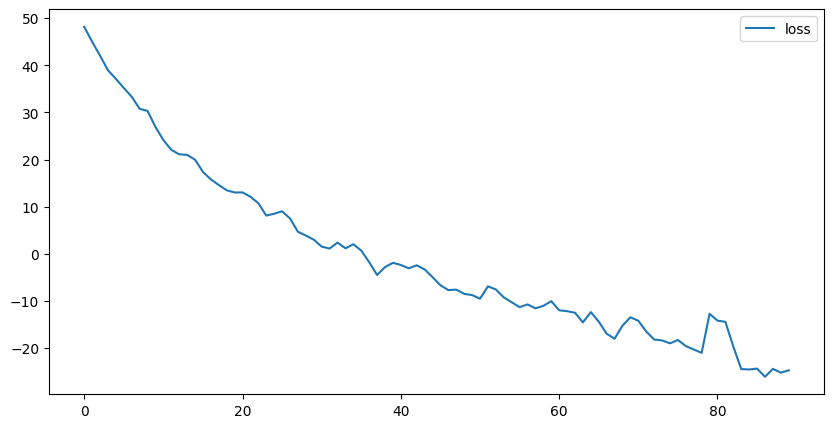

In [40]:
epochs = 100
optimizer = torch.optim.Adamax(rnvp.parameters(), lr=1e-2, weight_decay=1e-5)
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda _: 0.999)

loss_hist = train_loop(rnvp, optimizer, scheduler, faces_dataloader, epochs)

plt.figure(figsize=(10, 5))
plt.plot(loss_hist[epochs//10:], label='loss')
plt.legend()
plt.show()

In [41]:
nim = 4
samples = rnvp.sample(num_samples=nim*nim)[0].cpu().detach().numpy()


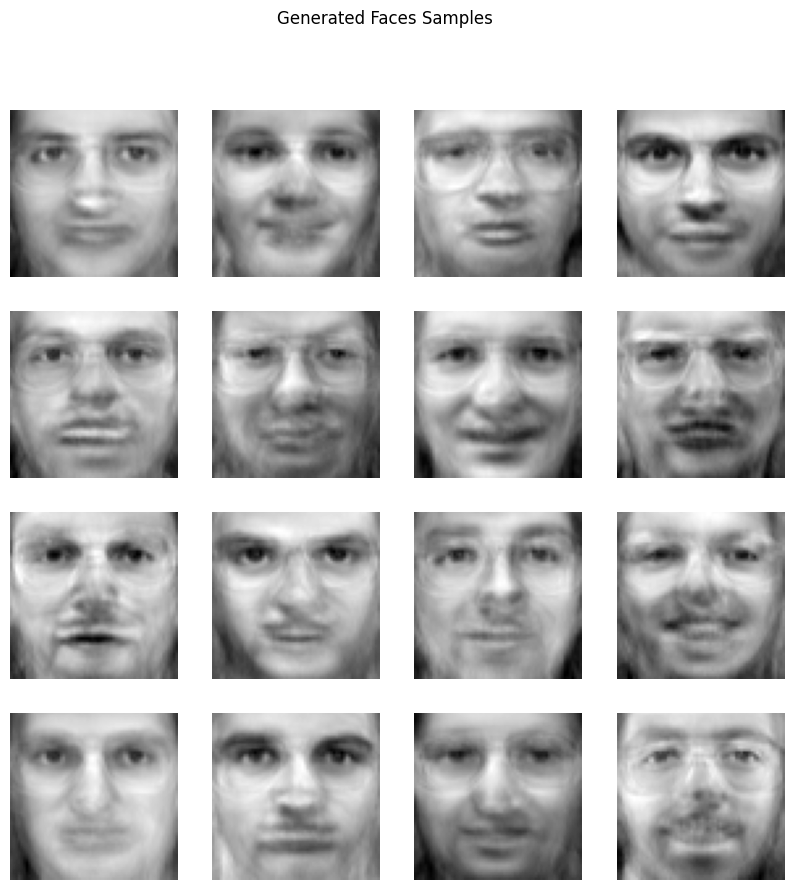

In [43]:
nim = 4
samples = rnvp.sample(num_samples=nim*nim)[0].cpu().detach().numpy()
samples_for_reconstruction = samples[:, :X_pca.shape[1]]
reconstructed_samples = pca.inverse_transform(samples_for_reconstruction)

# Visualize samples
fig = plt.figure(figsize=(10, 10))
for i in range(nim*nim):
    plt.subplot(nim, nim, i+1)
    plt.imshow(reconstructed_samples[i].reshape(faces.images[0].shape), cmap='gray')
    plt.axis('off')
plt.suptitle('Generated Faces Samples')
plt.show()

In [45]:
log_prob = rnvp.log_prob(torch.tensor(X_pca_padded, dtype=torch.float32).to(device)).detach().sum()
print(f"Log Probability of all the samples: {log_prob.item()}")

Log Probability of all the samples: 9068.9453125


In [46]:
for classe in range(30):
  d1 = np.where(faces.target == classe)[0][0]

  log_prob = rnvp.log_prob(torch.tensor(X_pca_padded[d1], dtype=torch.float32).to(device)).detach().sum()
  print(f"Log Probability of class {classe} samples: {log_prob.item()}")


Log Probability of class 0 samples: 1661.38623046875
Log Probability of class 1 samples: 627.60693359375
Log Probability of class 2 samples: 2063.2255859375
Log Probability of class 3 samples: 1191.080078125
Log Probability of class 4 samples: 2995.3740234375
Log Probability of class 5 samples: 2313.822265625
Log Probability of class 6 samples: 1223.44873046875
Log Probability of class 7 samples: -2565.50146484375
Log Probability of class 8 samples: 2201.146484375
Log Probability of class 9 samples: 817.927734375
Log Probability of class 10 samples: 1403.130859375
Log Probability of class 11 samples: 1738.14013671875
Log Probability of class 12 samples: 2521.16943359375
Log Probability of class 13 samples: 1387.490234375
Log Probability of class 14 samples: 2359.14404296875
Log Probability of class 15 samples: 1879.3154296875
Log Probability of class 16 samples: 766.55224609375
Log Probability of class 17 samples: 1942.9775390625
Log Probability of class 18 samples: 1338.48779296875
Lo

In [47]:


d1 = np.where(faces.target == 21)[0][0]
d2 = np.where(faces.target == 30)[0][0]


start = rnvp.inverse(torch.FloatTensor(X_pca_padded[d1]).to(device))
end = rnvp.inverse(torch.FloatTensor(X_pca_padded[d2]).to(device))



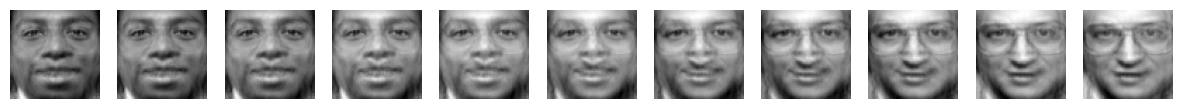

In [48]:
interp = []

for v in torch.arange(0,1.1,0.1):
    interp.append(torch.lerp(start,end, v.to(device)))


fig = plt.figure(figsize=(15,10))
for i, v in enumerate(interp):
    plt.subplot(1, len(interp), i+1)
    inv = (rnvp(v).cpu().detach().numpy())
    samples_for_reconstruction = inv[:, :X_pca.shape[1]]

    reconstructed = pca.inverse_transform(samples_for_reconstruction)

    plt.imshow(reconstructed.reshape(faces.images[0].shape),cmap='gray')
    plt.axis('off')

[[0.3529412  0.3529412  0.34901962 ... 0.49019608 0.47843137 0.47058824]]
[[0.3529412  0.3529412  0.34901962 ... 0.49019608 0.47843137 0.47058824]]


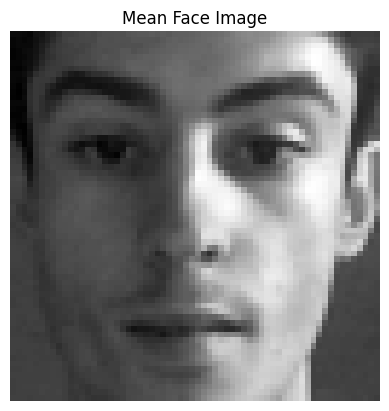

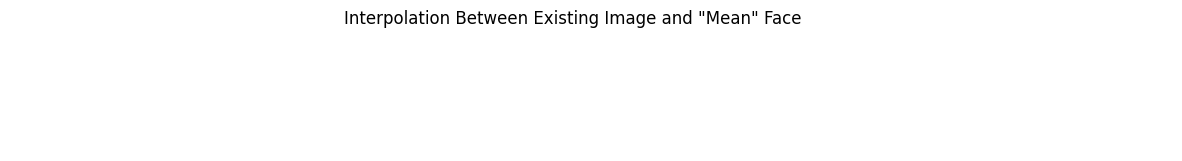

In [57]:
import cv2
from google.colab import files
from io import BytesIO
from PIL import Image

def preprocess_image(img_path, target_shape=(64, 64)):
    img = Image.open(img_path).convert("L")
    img = img.resize(target_shape)
    img = np.array(img, dtype=np.float32) / 255.0
    return img

def normalize_image(image, faces_data):
    mean_faces = np.mean(faces_data, axis=0)
    std_faces = np.std(faces_data, axis=0)

    normalized_image = (image - mean_faces) / (std_faces + 1e-10)

    return image # WE FOUND OUT WE HAD BETTER RESULTS WITH UNNORMALIZED IMAGES


image_path = "/content/face3.jpg"
user_img = preprocess_image(image_path)

user_img_flat = user_img.flatten().reshape(1, -1)  # Flatten image to match PCA input
user_img_prenorm = user_img_flat

print(user_img_prenorm)
user_img = normalize_image(user_img_flat, faces.data)
print(user_img)

plt.imshow(user_img.reshape(64,64), cmap='gray')
plt.title("Mean Face Image")
plt.axis('off')
plt.show()

user_img_flat = user_img.flatten().reshape(1, -1)
user_img_pca = pca.transform(user_img_flat)

# IN REALITY WE DON'T NEED THIS PADDING
user_img_pca_padded = np.zeros((1, latent_size))
user_img_pca_padded[:, :user_img_pca.shape[1]] = user_img_pca

# Find an existing image from the Olivetti dataset for interpolation
existing_img_index = np.where(faces.target == 15)[0][0]  # Example: Face from class 21
existing_img_pca_padded = X_pca_padded[existing_img_index]

start = rnvp.inverse(torch.FloatTensor(existing_img_pca_padded).to(device))
end = rnvp.inverse(torch.FloatTensor(user_img_pca_padded).to(device))


interp = []
for v in torch.arange(0, 1.1, 0.1):
    interp.append(torch.lerp(start, end, v.to(device)))

fig = plt.figure(figsize=(15, 2))
for i, v in enumerate(interp):
    plt.subplot(1, len(interp), i + 1)
    inv = rnvp(v).cpu().detach().numpy()
    samples_for_reconstruction = inv[:, :X_pca.shape[1]]
    reconstructed = pca.inverse_transform(samples_for_reconstruction)
    plt.imshow(reconstructed.reshape(faces.images[0].shape), cmap='gray')
    plt.axis('off')
plt.suptitle('Interpolation Between Existing Image and "Mean" Face')
plt.show()


 # IF INTERPOLATION APPEARS WHITE, IT MEANS THAT THERE ARE NANS / INFS IN THE LATENT -> THE MODEL ISN'T ABLE TO GENERALIZE

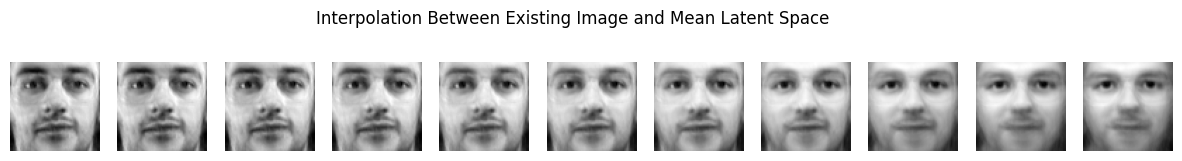

In [59]:
latent_representations = []
for img in X_pca_padded:
    latent_repr = rnvp.inverse(torch.FloatTensor(img).to(device))
    latent_representations.append(latent_repr.cpu().detach().numpy())

latent_representations = np.concatenate(latent_representations, axis=0)

mean_latent_vector = np.mean(latent_representations, axis=0)

existing_img_index = np.where(faces.target == 15)[0][0]
existing_img_pca_padded = X_pca_padded[existing_img_index]

start = rnvp.inverse(torch.FloatTensor(existing_img_pca_padded).to(device))
end = rnvp.inverse(torch.FloatTensor(mean_latent_vector).to(device))

interp = []
for v in torch.arange(0, 1.1, 0.1):
    interpolated_latent = torch.lerp(start, end, v.to(device))
    interp.append(interpolated_latent)

fig = plt.figure(figsize=(15, 2))
for i, v in enumerate(interp):
    plt.subplot(1, len(interp), i + 1)
    inv = rnvp(v).cpu().detach().numpy()
    samples_for_reconstruction = inv[:, :X_pca.shape[1]]
    reconstructed = pca.inverse_transform(samples_for_reconstruction)
    plt.imshow(reconstructed.reshape(faces.images[0].shape), cmap='gray')
    plt.axis('off')
plt.suptitle('Interpolation Between Existing Image and Mean Latent Space')
plt.show()

# In this model, the mean latent is a bit different from the one shown in the report

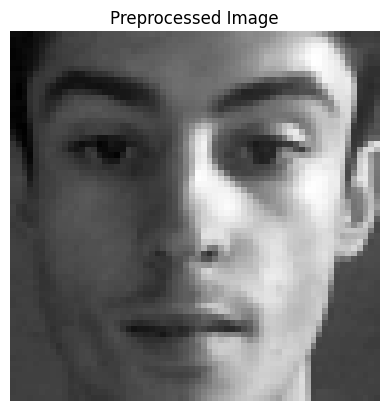

Reconstructed min: 0.1260930299758911, max: 0.9986273646354675


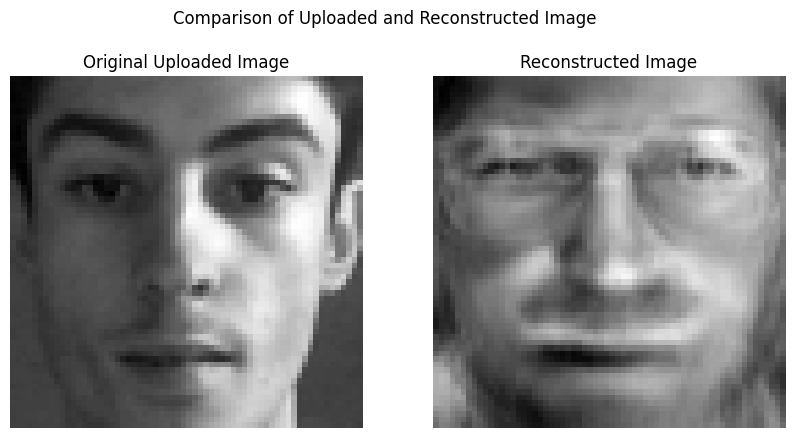

In [74]:
image_path = "/content/face3.jpg"
user_img = preprocess_image(image_path)

# Display the preprocessed image
plt.imshow(user_img, cmap='gray')
plt.title("Preprocessed Image")
plt.axis('off')
plt.show()

# Flatten and apply PCA
user_img_flat = user_img.flatten().reshape(1, -1)  # Flatten image to match PCA input
user_img_pca = pca.transform(user_img_flat) / 1.5 # IF WE DIVIDE, WE CAN FIND MORE EASILLY IMAGES THAT ARE IN DISTRIBUTION

user_img_pca_padded = np.zeros((1, latent_size))
user_img_pca_padded[:, :user_img_pca.shape[1]] = user_img_pca

user_img_latent = rnvp.inverse(torch.FloatTensor(user_img_pca_padded).to(device))

user_img_latent = torch.clamp(user_img_latent, -10, 10) # WE ALSO NEED TO CLAMP THE LATENT

reconstructed_latent = rnvp(user_img_latent).cpu().detach().numpy()
samples_for_reconstruction = reconstructed_latent[:, :X_pca.shape[1]]
reconstructed_image = pca.inverse_transform(samples_for_reconstruction)

print(f"Reconstructed min: {reconstructed_image.min()}, max: {reconstructed_image.max()}")


reconstructed_image = np.clip(reconstructed_image, 0, 1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(user_img.reshape(64, 64), cmap='gray')
plt.title("Original Uploaded Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image.reshape(64, 64), cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')

plt.suptitle("Comparison of Uploaded and Reconstructed Image")
plt.show()


